In [1]:
!pip install scikeras | grep -v 'Requirement already satisfied'

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from lightgbm import LGBMRegressor
from matplotlib import pyplot as plt
from scikeras.wrappers import KerasRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as mse, r2_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from tensorflow.keras import callbacks, layers, Sequential

In [3]:
filepath = '/kaggle/input/renewable-energy-and-weather-conditions/solar_weather.csv'

df = pd.read_csv(filepath, parse_dates = ['Time'])

display(df)

,Time,Energy delta[Wh],GHI,temp,pressure,humidity,wind_speed,rain_1h,snow_1h,clouds_all,isSun,sunlightTime,dayLength,SunlightTime/daylength,weather_type,hour,month
0,2017-01-01 00:00:00,0,0.0,1.6,1021,100,4.9,0.0,0.0,100,0,0,450,0.00,4,0,1
1,2017-01-01 00:15:00,0,0.0,1.6,1021,100,4.9,0.0,0.0,100,0,0,450,0.00,4,0,1
2,2017-01-01 00:30:00,0,0.0,1.6,1021,100,4.9,0.0,0.0,100,0,0,450,0.00,4,0,1
3,2017-01-01 00:45:00,0,0.0,1.6,1021,100,4.9,0.0,0.0,100,0,0,450,0.00,4,0,1
4,2017-01-01 01:00:00,0,0.0,1.7,1020,100,5.2,0.0,0.0,100,0,0,450,0.00,4,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196771,2022-08-31 16:45:00,118,23.7,18.6,1023,57,3.8,0.0,0.0,52,1,780,825,0.95,3,16,8
196772,2022-08-31 17:00:00,82,15.6,18.5,1023,61,4.2,0.0,0.0,60,1,795,825,0.96,3,17,8
196773,2022-08-31 17:15:00,51,8.0,18.5,1023,61,4.2,0.0,0.0,60,1,810,825,0.98,3,17,8
196774,2022-08-31 17:30:00,24,2.1,18.5,1023,61,4.2,0.0,0.0,60,1,825,825,1.00,3,17,8


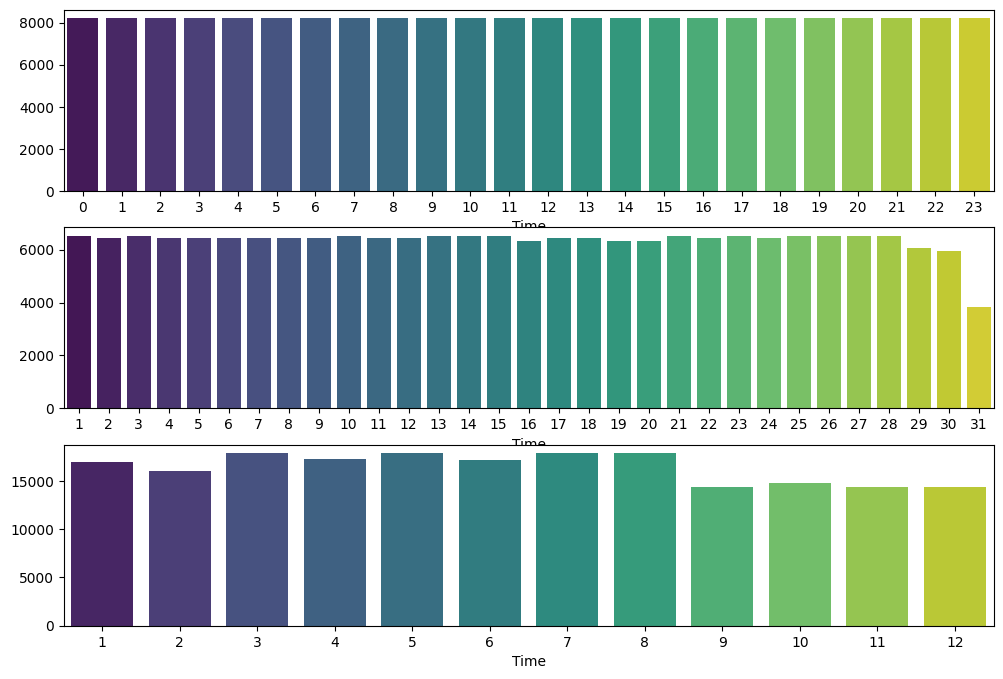

In [4]:
fig, axes = plt.subplots(3, 1, figsize = (12, 8))

hours = df['Time'].dt.hour
count_hours = hours.value_counts()
sns.barplot(x = count_hours.index, y = count_hours.values, ax = axes[0], palette = 'viridis')

days = df['Time'].dt.day
count_days = days.value_counts()
sns.barplot(x = count_days.index, y = count_days.values, ax = axes[1], palette = 'viridis')

months = df['Time'].dt.month
count_months = months.value_counts()
sns.barplot(x = count_months.index, y = count_months.values, ax = axes[2], palette = 'viridis')

plt.show()

In [5]:
ts_df = df[['Time', 'temp', 'Energy delta[Wh]']].copy()

ts_df['date'] = pd.to_datetime(ts_df['Time'].dt.date)

ts_df = ts_df.drop(columns = ['Time'])

display(ts_df.head(10))

,temp,Energy delta[Wh],date
0,1.6,0,2017-01-01
1,1.6,0,2017-01-01
2,1.6,0,2017-01-01
3,1.6,0,2017-01-01
4,1.7,0,2017-01-01
5,1.7,0,2017-01-01
6,1.7,0,2017-01-01
7,1.7,0,2017-01-01
8,1.9,0,2017-01-01
9,1.9,0,2017-01-01


In [6]:
dates_df = ts_df.groupby(['date'])[['temp']].agg([max, min, np.mean])

dates_df = dates_df.reset_index()

dates_df.columns = ['date', 'max_temp', 'min_temp', 'avg_temp']

dates_df.set_index('date', inplace = True)

display(dates_df)

,max_temp,min_temp,avg_temp
date,,,
2017-01-01,3.9,1.6,2.975000
2017-01-02,2.5,-2.2,0.850000
2017-01-03,4.7,-2.3,1.420833
2017-01-04,2.8,-1.3,1.166667
2017-01-10,-2.0,-7.8,-3.854167
...,...,...,...
2022-08-27,26.6,17.1,21.191667
2022-08-28,22.0,13.2,18.829167
2022-08-29,20.8,12.9,16.525000


In [7]:
lagged_df = dates_df.copy()

shifted = 1

for feature in lagged_df.columns:
    lagged_df[f'{feature}_lag'] = lagged_df[feature].shift(shifted)

display(lagged_df)

,max_temp,min_temp,avg_temp,max_temp_lag,min_temp_lag,avg_temp_lag
date,,,,,,
2017-01-01,3.9,1.6,2.975000,NaN,NaN,NaN
2017-01-02,2.5,-2.2,0.850000,3.9,1.6,2.975000
2017-01-03,4.7,-2.3,1.420833,2.5,-2.2,0.850000
2017-01-04,2.8,-1.3,1.166667,4.7,-2.3,1.420833
2017-01-10,-2.0,-7.8,-3.854167,2.8,-1.3,1.166667
...,...,...,...,...,...,...
2022-08-27,26.6,17.1,21.191667,29.7,18.7,22.975000
2022-08-28,22.0,13.2,18.829167,26.6,17.1,21.191667
2022-08-29,20.8,12.9,16.525000,22.0,13.2,18.829167


In [8]:
X = lagged_df.reset_index()[['max_temp_lag', 'min_temp_lag', 'avg_temp_lag']][shifted:]
y = lagged_df.reset_index()[['max_temp', 'min_temp', 'avg_temp']][shifted:]
dates = dates_df.index[shifted:]

In [9]:
splitter = lambda array, size: (array[:size].copy(), array[size:].copy())

def model_result(model, X, y, dates, model_name, train_size = 0.5, scaling = False):
    size = int(X.shape[0] * train_size)
    
    train_X, test_X = splitter(X, size)
    train_y, test_y = splitter(y, size)
    train_dates, test_dates = splitter(dates, size)
    
    if scaling:
        scaler = StandardScaler()
        train_X = scaler.fit_transform(train_X)
        test_X = scaler.transform(test_X)
        
    model.fit(train_X, train_y)
    
    train_pred = pd.DataFrame(model.predict(train_X), columns = y.columns)
    test_pred = pd.DataFrame(model.predict(test_X), columns = y.columns)
    
    fig, axes = plt.subplots(3, 1, figsize = (12, 24))
    
    for target, ax in zip(y.columns, axes):
        train_r2 = r2_score(train_y[target], train_pred[target])
        train_mse = mse(train_y[target], train_pred[target])
        
        sns.lineplot(
            x = train_dates,
            y = train_pred[target],
            ax = ax, 
            label = 'Train',
            color = 'DarkBlue'
        )
        
        test_r2 = r2_score(test_y[target], test_pred[target])
        test_mse = mse(test_y[target], test_pred[target])
    
        sns.lineplot(
            x = test_dates,
            y = test_pred[target],
            ax = ax, 
            label = 'Test',
            color = 'DarkGreen'
        )
        
        title = f'{model_name} {target} prediction\n'
        title += f'train r2 score = {train_r2} - test r2 score = {test_r2}\n'
        title += f'train mse = {train_mse} - test mse = {test_mse}'
    
        ax.set_title(title)
        
        sns.scatterplot(x = dates, y = y[target], ax = ax, color = 'black')
        
    plt.show()

In [10]:
lgbr = LGBMRegressor(num_leaves = 19, n_estimators = 84, learning_rate = 0.15)

lgbr_multiout = MultiOutputRegressor(lgbr)

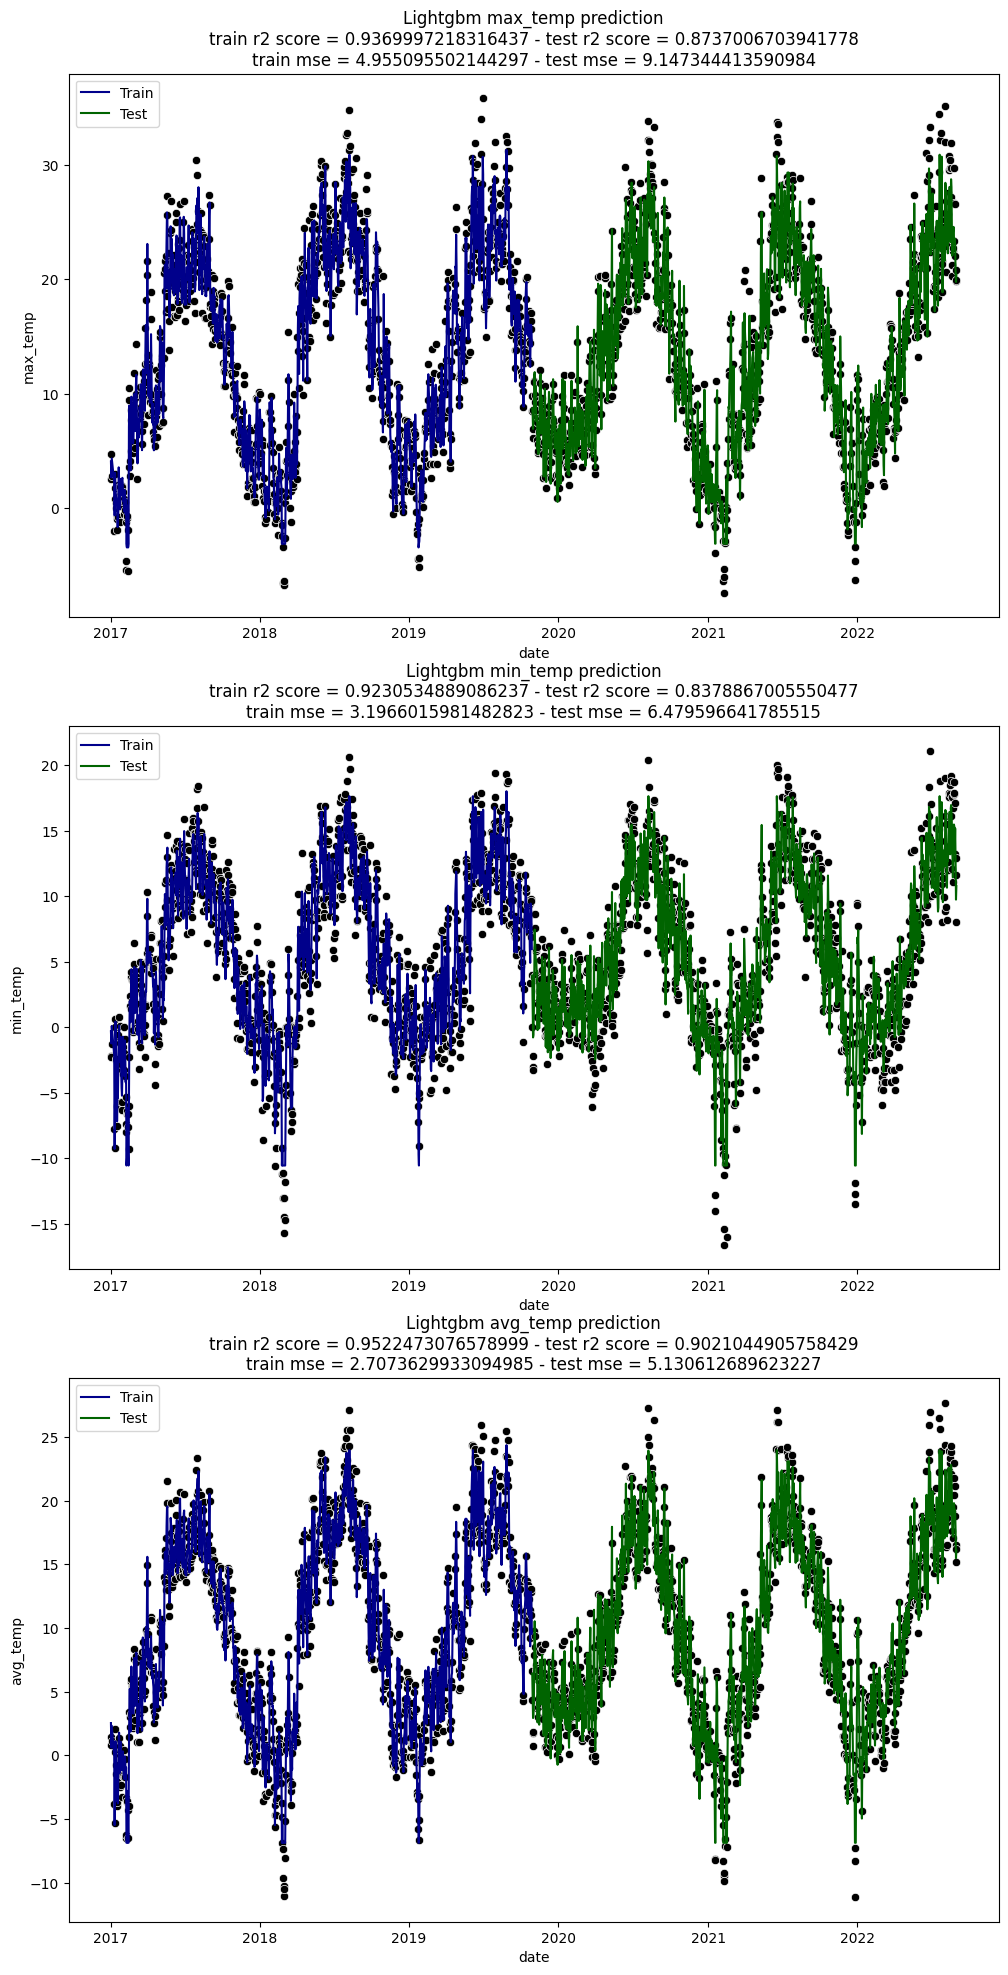

In [11]:
model_result(lgbr_multiout, X, y, dates, 'Lightgbm')

In [12]:
forest = RandomForestRegressor(random_state = 1, max_leaf_nodes = 64, n_estimators = 54, n_jobs = 4)

forest_multiout = MultiOutputRegressor(forest)

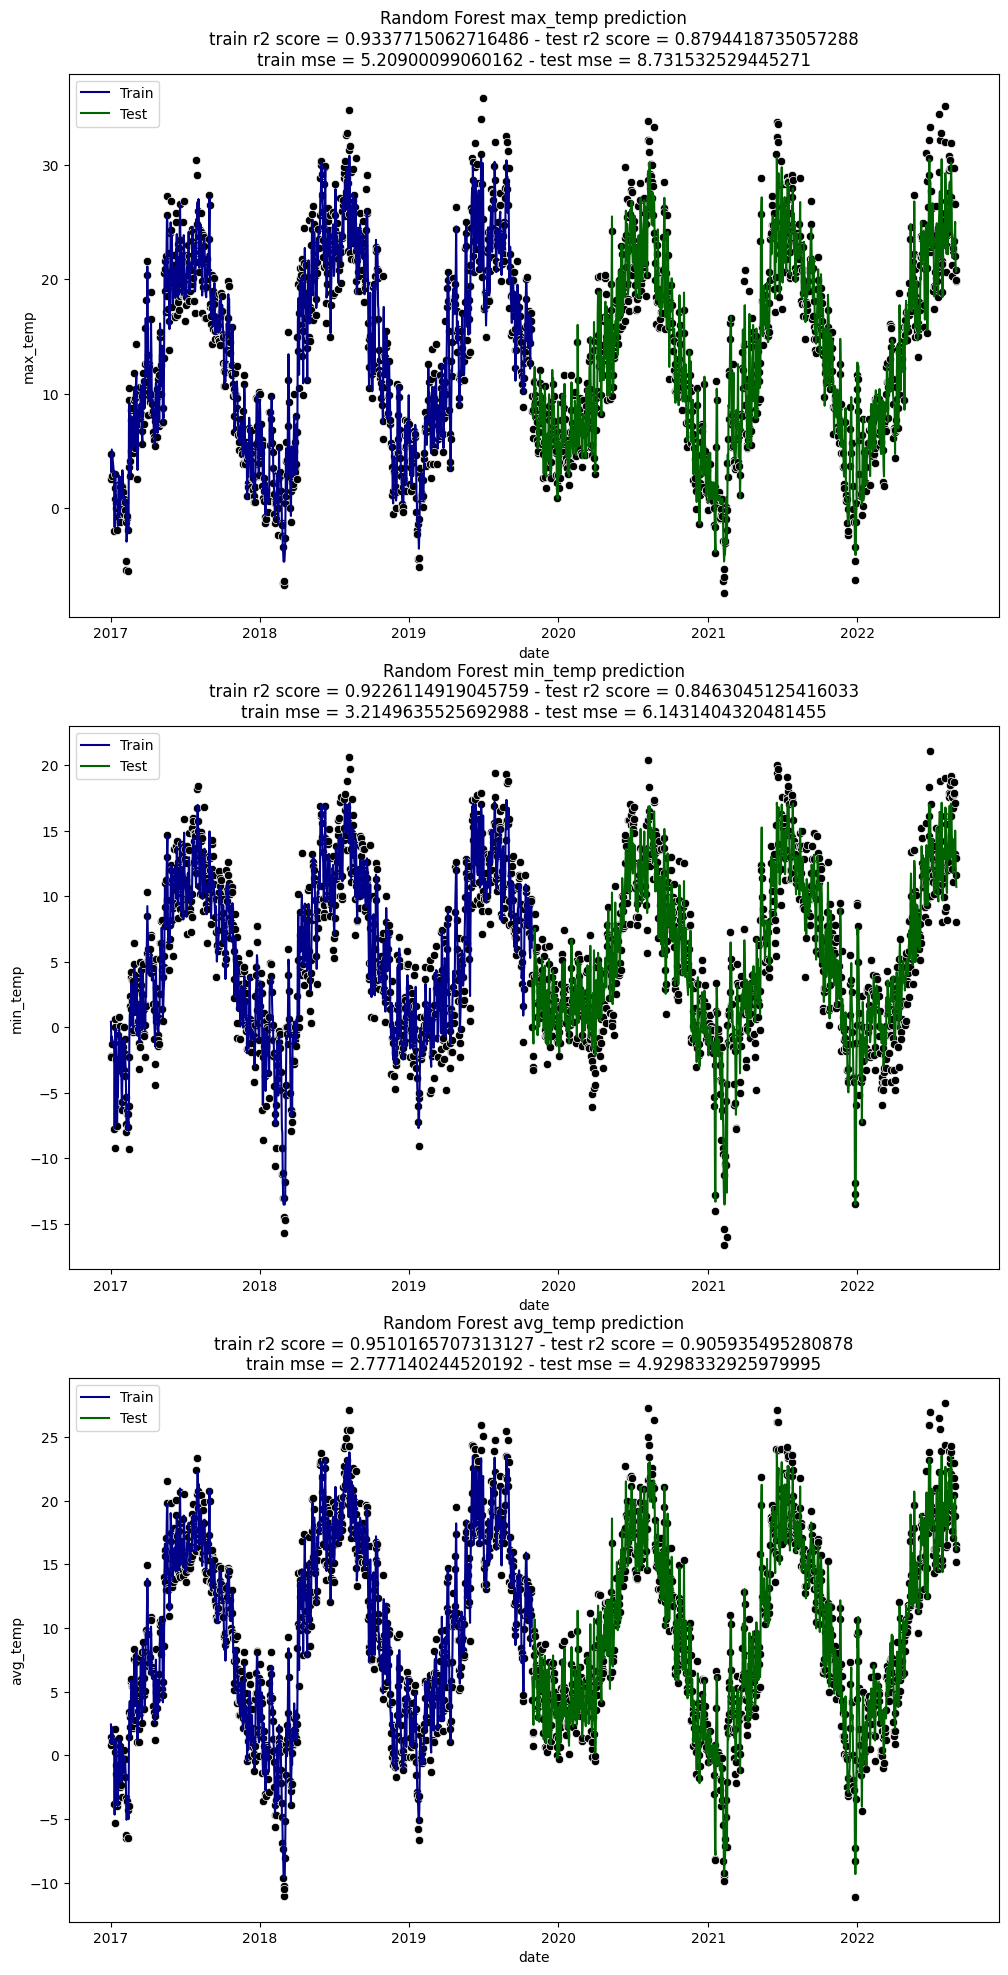

In [13]:
model_result(forest_multiout, X, y, dates, 'Random Forest')

In [14]:
svr = SVR(C = 1, gamma = 0.1)

svr_multiout = MultiOutputRegressor(svr, n_jobs = 2)

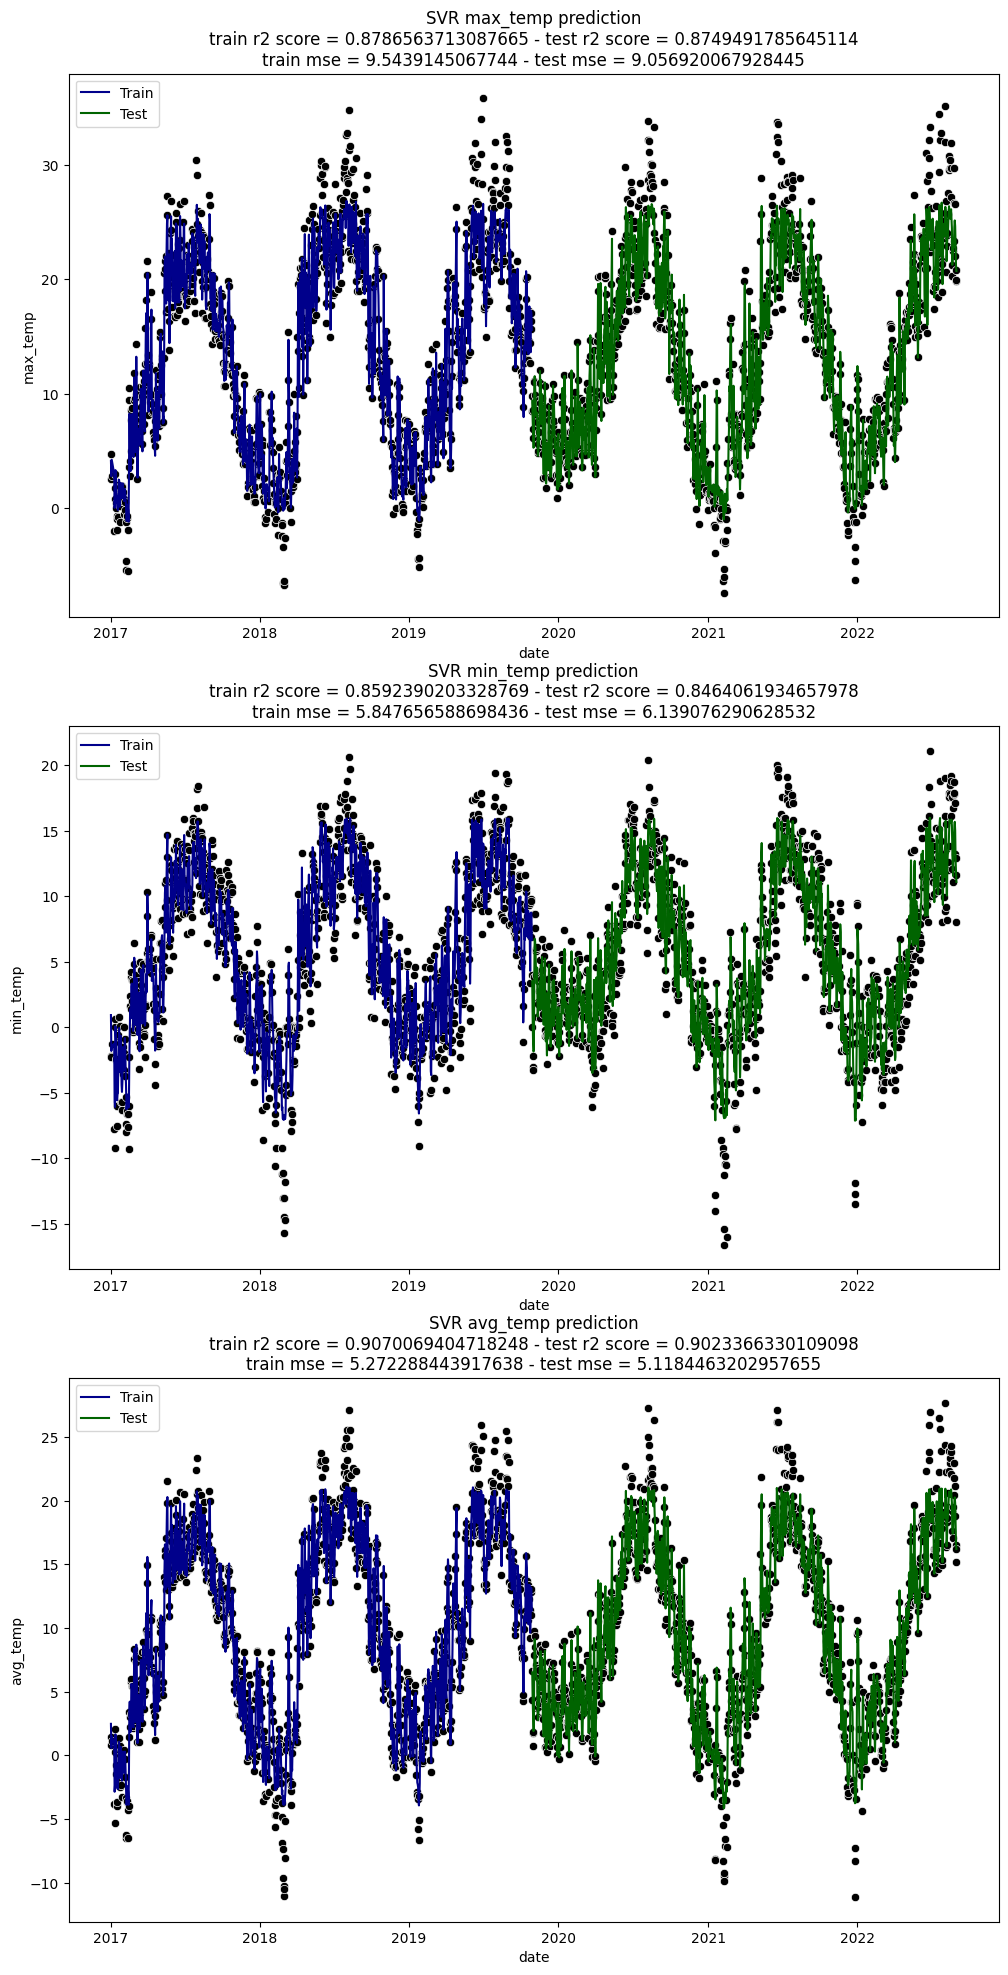

In [15]:
model_result(svr_multiout, X, y, dates, 'SVR', scaling = True)

In [16]:
early_stopping = callbacks.EarlyStopping(patience = 5)

nn = Sequential([
        layers.Dense(32, input_shape = [X.shape[1]], activation = 'relu'),
        layers.Dense(16),
        layers.Dense(16),
        layers.Dense(y.shape[1])
     ])

nn.compile(optimizer = 'adam', loss = 'mse', metrics = ['mae'])

scikeras_model = KerasRegressor(nn, epochs = 104, verbose = 0, callbacks = [early_stopping])

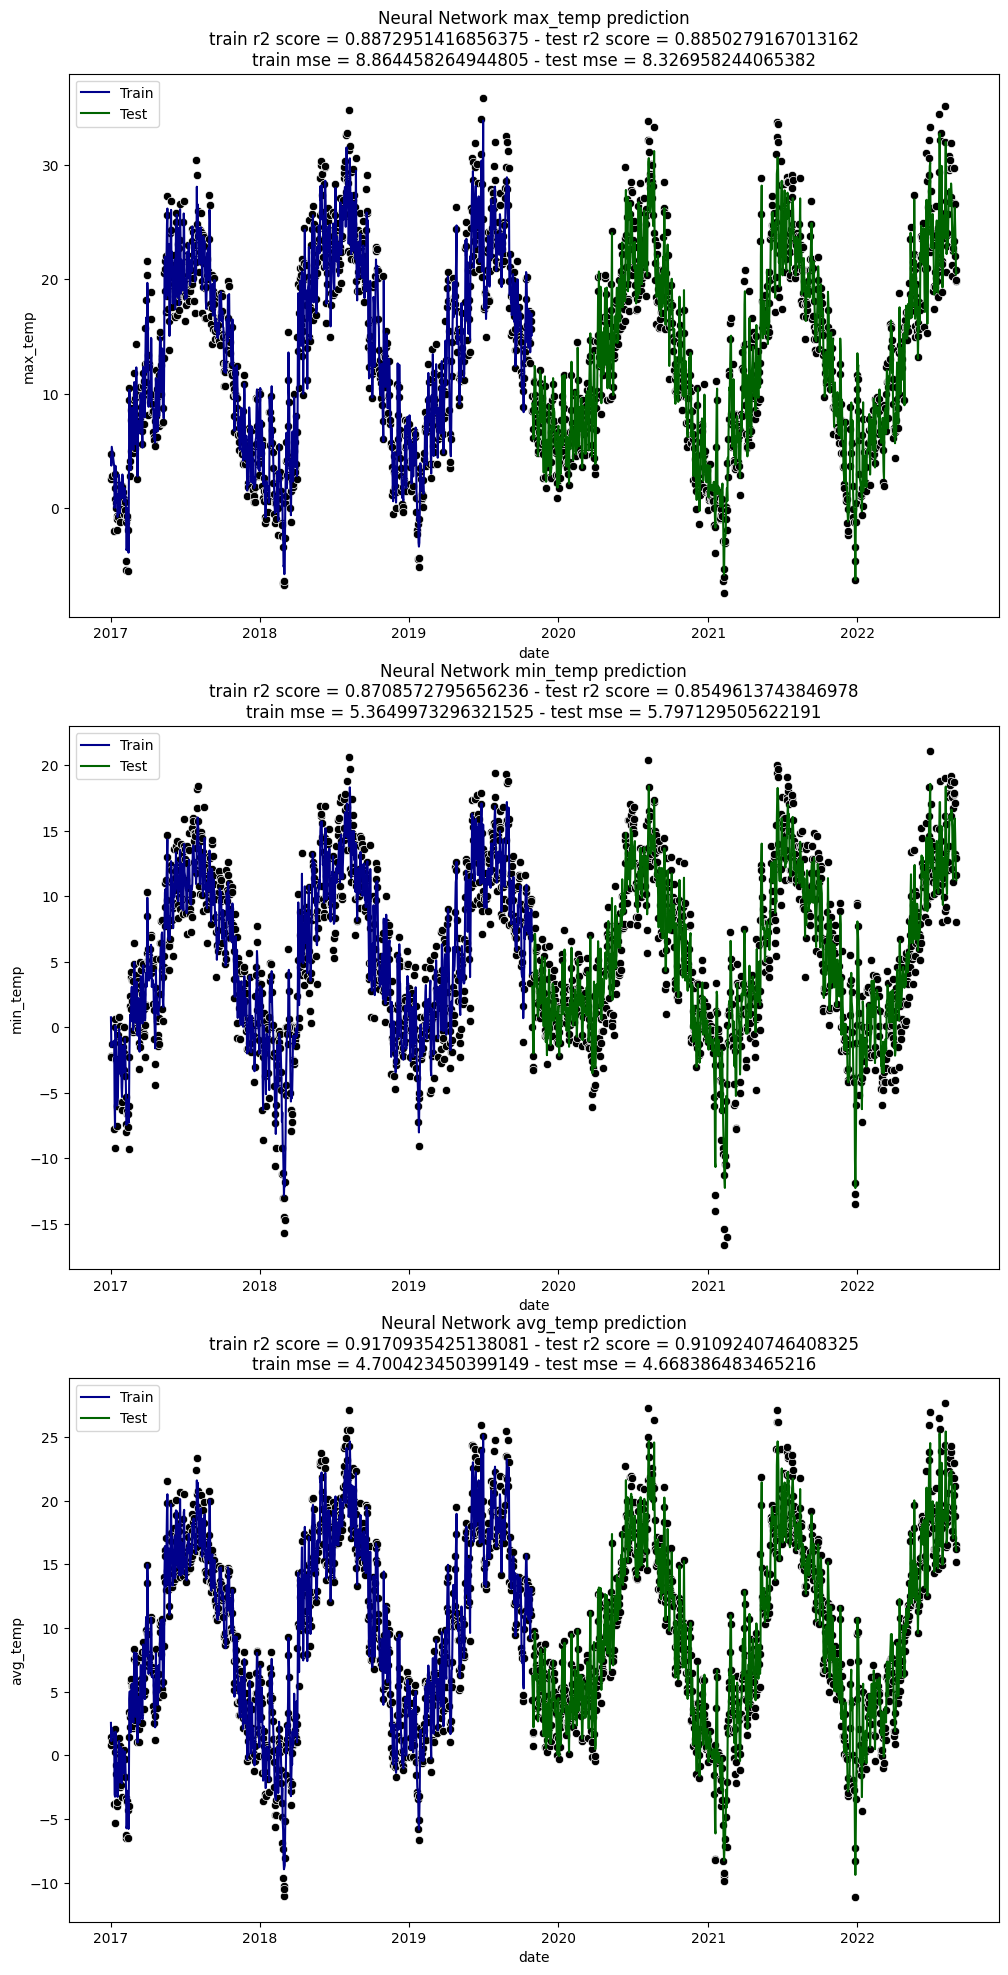

In [17]:
model_result(scikeras_model, X, y, dates, 'Neural Network', scaling = True)